# Interacting with projects

In [8]:
from rasterfoundry.api import API
refresh_token = '<INSERT-TOKEN>'
api = API(refresh_token=refresh_token)

## List projects

If you have access to any projects, `api.projects` will return them as a list.

In [2]:
projects = api.projects
projects

[<Project - oakland - 2017-07-23>,
 <Project - DG - Test Import>,
 <Project - NAIP Sample>,
 <Project - long-beach - 2017-03-23>,
 <Project - long-beach - 2017-07-10>,
 <Project - long-beach - 2017-08-30>,
 <Project - long-beach - 2017-08-19>,
 <Project - long-beach - 2017-05-18>,
 <Project - long-beach - 2017-07-31>,
 <Project - long-beach - 2017-07-26>,
 <Project - long-beach - 2017-04-30>,
 <Project - PA Railcars - DO NOT LABEL>,
 <Project - NAIP - North Platte Nebraska Rail Yard>,
 <Project - PA-Rail-Car-WEB_M_PA_X21_Y081>,
 <Project - PA-Rail-Car-WEB_M_PA_X18_Y081>,
 <Project - hong kong - 2017-07-11>,
 <Project - Planetscope Test>,
 <Project - long-beach - 2017-07-06>,
 <Project - long-beach - 2017-07-19>,
 <Project - long-beach - 2017-04-11>,
 <Project - long-beach - 2017-09-02>,
 <Project - long-beach - 2017-08-18>,
 <Project - long-beach - 2017-07-29>,
 <Project - long-beach - 2017-09-10>,
 <Project - long-beach - 2017-06-01>,
 <Project - long-beach - 2017-08-22>,
 <Project - 

In [3]:
china_before = [project for project in projects if project.name == 'China Aluminum (Before Collapse)'][0]
china_after = [project for project in projects if project.name == 'China Aluminum (After Collapse)'][0]
singapore = [project for project in projects if project.name == 'Singapore - June 15, 2017'][0]

## Display a project

You can choose one of your projects with ingested scenes and add it to a leaflet map
in the browser.

In [4]:
china_map = china_after.get_map()
china_after.add_to(china_map)
china_before.compare(china_after, china_map)
china_map

In [5]:
# Change the index in projects[3] to a value within your list of projects
m = singapore.get_map()
singapore.add_to(m)
m

# Project export

## Export as PNG

In [6]:
from ipyleaflet import DrawControl
dc = DrawControl()
m.add_control(dc)

In [7]:
dc.last_draw['geometry']
def get_bbox(geom):
    coords = geom['coordinates']
    min_x = min([i[0]] for i in coords[0])[0]
    max_x = max([i[0]] for i in coords[0])[0]

    min_y = min([i[1]] for i in coords[0])[0]
    max_y = max([i[1]] for i in coords[0])[0]

    return '{min_x},{min_y},{max_x},{max_y}'.format(
        min_x=min_x, min_y=min_y, max_x=max_x, max_y=max_y
    )
print dc.last_draw

{'geometry': {'type': 'Polygon', 'coordinates': [[[103.87521743774414, 1.2502339631466663], [103.87521743774414, 1.2502339631466663], [103.88586044311522, 1.2076717353497797], [103.88586044311522, 1.2076717353497797], [103.93735885620117, 1.241309681447832], [103.93735885620117, 1.241309681447832], [103.92396926879883, 1.2577852547444972], [103.92396926879883, 1.2577852547444972], [103.87521743774414, 1.2502339631466663]]]}, 'type': 'Feature', 'properties': {'style': {'opacity': 0.5, 'noClip': False, 'weight': 4, 'color': '#f06eaa', 'lineCap': None, 'stroke': True, 'smoothFactor': 1, 'dashArray': None, 'fillOpacity': 0.2, 'clickable': True, 'lineJoin': None, 'fill': True, 'fillColor': None}}}


In [8]:
bbox = get_bbox(dc.last_draw['geometry'])
bbox

'103.875217438,1.20767173535,103.937358856,1.25778525474'

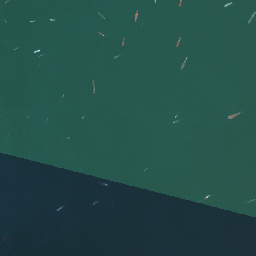

In [9]:
from IPython.display import Image
bbox = get_bbox(dc.last_draw['geometry'])
raw_png = singapore.png(bbox, zoom=14)
Image(raw_png)

In [10]:
%matplotlib inline

from math import sqrt

import imread
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

In [11]:
png = rgb2gray(imread.imload_from_blob(raw_png))

blobs = blob_log(png, min_sigma=0.7, max_sigma=13)

print 'Number of Ships Detected: {}'.format(len(blobs))

Number of Ships Detected: 7


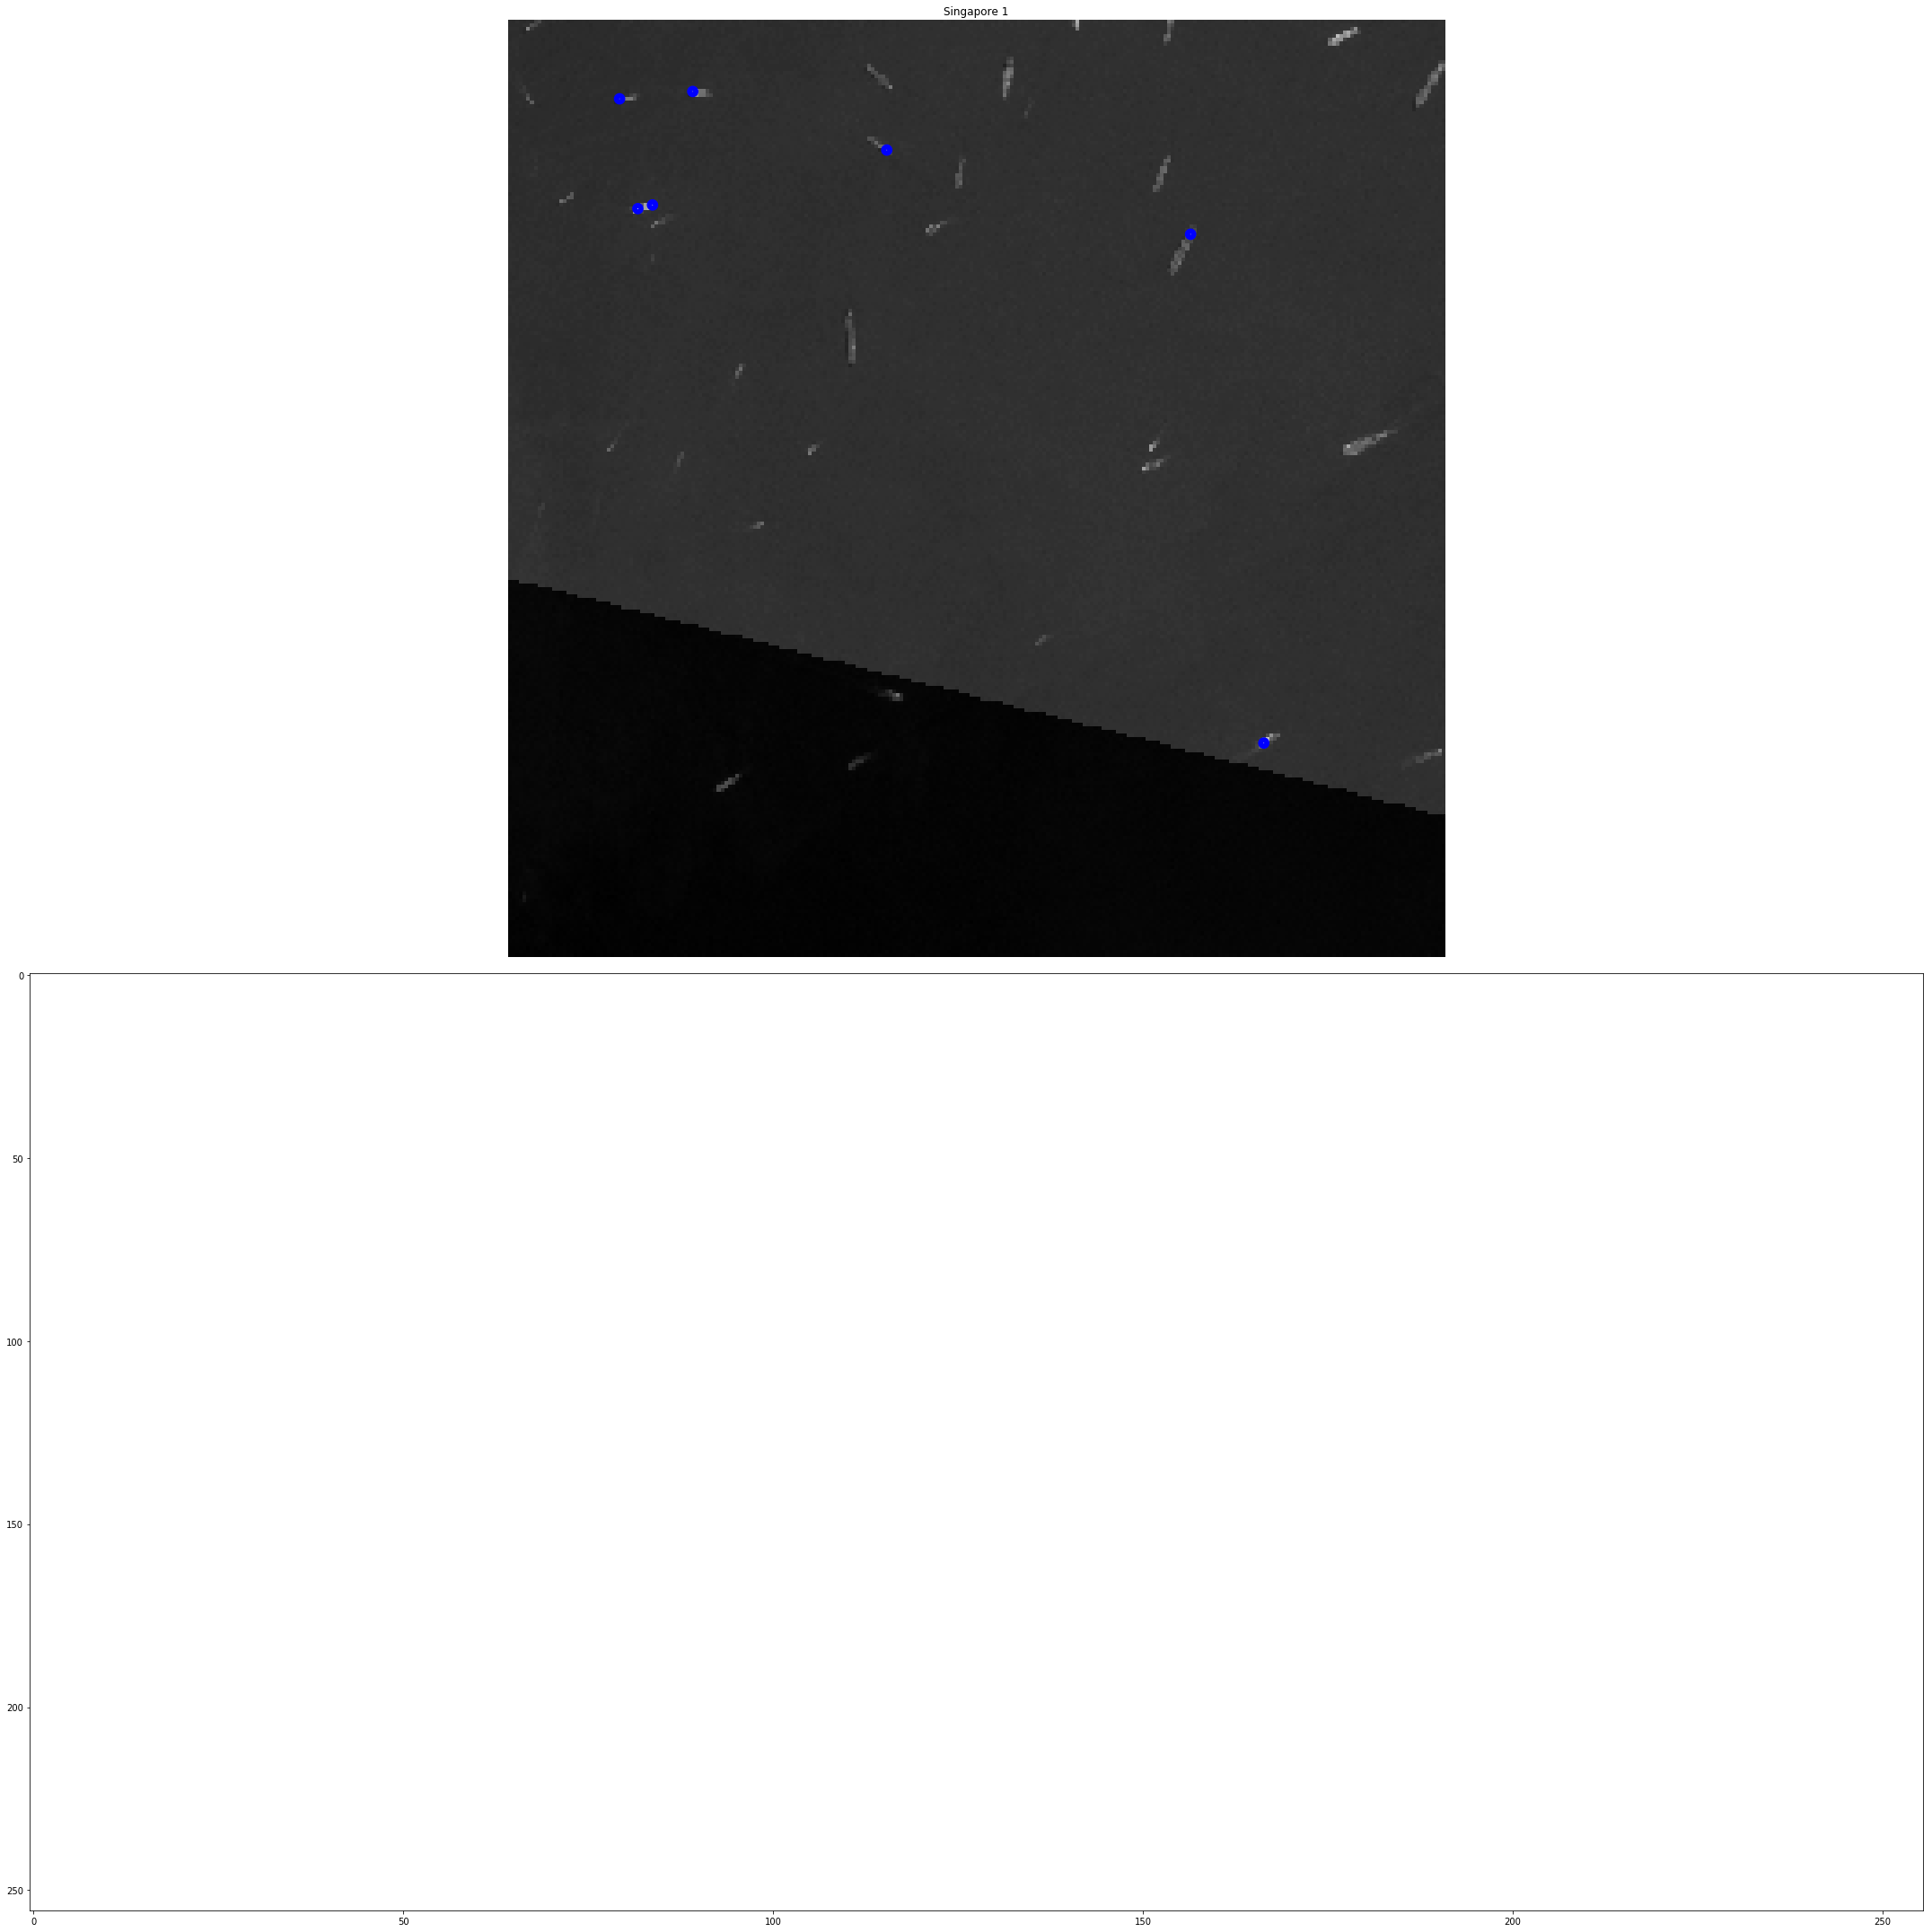

In [14]:
sequence = [(blobs, 'Singapore 1', png),]

fig, axes = plt.subplots(2, 1, figsize=(30, 30), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for idx, (blobs, title, img) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(img, cmap='gray', interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='blue', linewidth=7, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

# Raster Vision

## Prepare training data

In [3]:
from rasterfoundry.utils import RasterVisionBatchClient
rv_batch_client = RasterVisionBatchClient(branch_name='lf/filter')

# A set of projects and corresponding annotation GeoJSON files.
project_ids = [
    '357ddf1f-2e5e-4420-8e75-0eed12d2d20f',
    '1ab2734c-d2b1-4e0b-8c54-24f4f121c77b',
    'd64f334a-9c91-4bae-bc5e-2daa28c9470f',
    '72d1eadb-2e4b-4e07-81d6-cc78a1ff29a1',
    '7030c078-cf3e-403f-934a-cef039e56b2d',
    'f38d0ea0-1b11-4256-9ca6-5464ca30bbaf'
]

annotation_uris = [
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-09-18-singapore-final.geojson',
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-07-04-panama-final.geojson',
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-07-23-oakland-final.geojson',
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-08-27-richmond-final.geojson',
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-08-01-singapore-final.geojson',
    's3://raster-vision-od/raw-data/annotations/jm-ships/2017-08-08-long-beach-final.geojson'
]

# Specify where to put the output, and start the Batch job.
output_zip_uri = 's3://raster-vision-od/training-data/jm-ships-single-label.zip'
label_map_uri = 's3://raster-vision-od/configs/labels-maps/jm-ships-single-label.pbtxt'

api.start_prep_train_data_job(
    rv_batch_client,
    project_ids, annotation_uris, output_zip_uri, label_map_uri)

u'ca3c5ea7-ed04-4122-8a8b-ff4146567a4f'

## Make predictions for project

In [6]:
# Make predictions using a trained model for the Oakland project.
oakland = projects[0]
inference_graph_uri = 's3://raster-vision-od/trained-models/lhf-ships-neg0/inference_graph.pb'
label_map_uri = 's3://raster-vision-od/training-data/jm-ships-single-label.pbtxt'
predictions_uri = 's3://raster-vision-od/predictions/oakland.json'
oakland.start_predict_job(rv_batch_client, inference_graph_uri,
                          label_map_uri, predictions_uri)

u'95971811-263c-4bbf-895c-f9de9f59e1ea'